# Black-Scholes Option Pricing

In this notebook I will go through the basics of Black-Scholes derivative pricing,
using the case of European put and call options as a simple example.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from black_scholes import call_european, put_european

%matplotlib inline

### Call option dependence on parameters

In the Black-Scholes model, the price of a call option depends on:
 1. $S$ : The price of the underlying
 2. $K$ : The strike price 
 3. $\sigma$ : The volatility 
 4. $T$ : Time to expiration
 5. $r$ : Risk-free rate of return
 6. $q$ : Continuous rate of dividend returns (if at all) 
 7. Discounted value of any dividend payouts (if at all) [Not yet implemented]
 
The basic formula is
$$ c = Se^{-qT}\Phi(d_1) - Ke^{-rT}\Phi(d_2) $$

where $\Phi$ is the cumulative distribution function of the unit normal distribution
$$ \Phi(z) \equiv \int_{-\infty}^z \frac{e^{-\frac{1}{2}x^2}}{\sqrt{2\pi}} {\rm d}x $$
and
$$ d_1 = \frac{1}{\sigma\sqrt{T}}\left[\ln(S/K) + \left(r-q+\frac{\sigma^2}{2}\right)T\right] $$
$$ d_2 = \frac{1}{\sigma\sqrt{T}}\left[\ln(S/K) + \left(r-q-\frac{\sigma^2}{2}\right)T\right] = d_1 - \sigma\sqrt{T}$$

It is straightforward to see that 
 - $\Delta \equiv \frac{\partial c}{\partial S} = \Phi(d_1)$, and
 - $\Phi(d_2)$ is the probability that the option will be exercised at maturity
 
*NOTE*: When we approach maturity, we can run into numerical problems if we try to naively evaluate this expression.

For a physicist, it is natural to try and reduce the number of independent parameters this expression depends on.
In particular, note the only the parameter combinations $Se^{-qT}$, $Ke^{-rT}$ and $\sigma\sqrt{T}$ appear (ignoring dividends with a known present value).  Therefore, if we define
 - $\bar{S} \equiv Se^{-qT}$
 - $\bar{K} \equiv Ke^{-rT}$
 - $\bar{\sigma} \equiv \sigma\sqrt{T}$

we have
$$ c = \bar{S}\Phi(d_1) - \bar{K}\Phi(d_2) $$
with
$$ d_1 = \frac{1}{\bar{\sigma}}\left[\ln\left(\bar{S}/\bar{K}\right) + \frac{\bar{\sigma}^2}{2} \right] $$
$$ d_2 = \frac{1}{\bar{\sigma}}\left[\ln\left(\bar{S}/\bar{K}\right) - \frac{\bar{\sigma}^2}{2} \right] $$
which only depends on 3 independent parameters instead of 6.

/Users/jbraden/Coding/Finance/black_scholes.py:98: RuntimeWarning: divide by zero encountered in divide
  return (np.log(s/k) + (r+0.5*vol**2)*t)/(vol*np.sqrt(t))
/Users/jbraden/Coding/Finance/black_scholes.py:95: RuntimeWarning: divide by zero encountered in divide
  return (np.log(s/k) + (r-0.5*vol**2)*t)/(vol*np.sqrt(t))


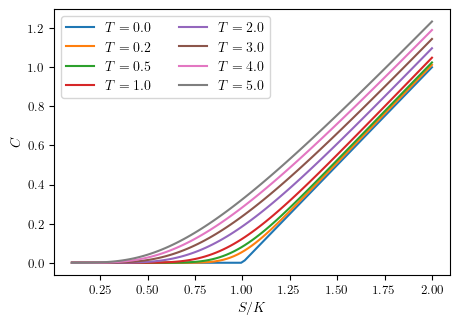

In [128]:
sVals = np.linspace(0.1,2.,101)

for t in [0.,0.25, 0.5, 1., 2., 3., 4., 5.]:
    plt.plot(sVals, call_european(sVals, 1., 0.05, 0.25, t), label=r'$T=%.1f$' % t)
    
plt.xlabel(r'$S/K$'); plt.ylabel(r'$C$')
plt.legend(ncols=2)

plt.show()

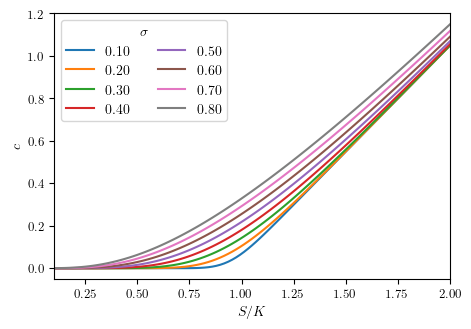

In [44]:
for s in np.linspace(0.1,0.8,8):
    plt.plot(sVals, call_european(sVals, 1., 0.05, s, 1.), label=r'$%.2f$'%s)
    
plt.xlabel(r'$S/K$'); plt.ylabel(r'$c$')

plt.ylim(-0.05,1.2); plt.xlim(sVals[0],sVals[-1])
plt.legend(title=r'$\sigma$',ncols=2)

plt.show()

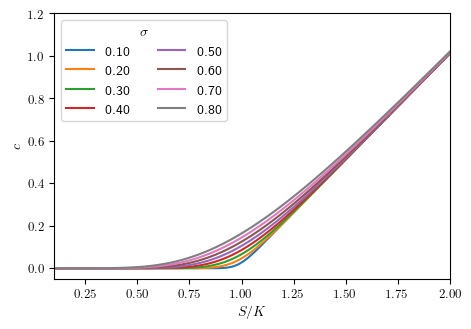

In [45]:
for s in np.linspace(0.1,0.8,8):
    plt.plot(sVals, call_european(sVals, 1., 0.05, s, 0.25), label=r'%.2f'%s)
    
plt.xlabel(r'$S/K$'); plt.ylabel(r'$c$')

plt.xlim(sVals[0],sVals[-1]); plt.ylim(-0.05,1.2)
plt.legend(title=r'$\sigma$', ncols=2)

plt.show()

## Options Combinations (Payoffs)

In [111]:
def call_payoff(s,k):
    z = np.zeros_like(s)
    return np.max(np.vstack([s-k,z]).T,axis=-1)

def put_payoff(s,k):
    z = np.zeros_like(s)
    return np.max(np.vstack([k-s,z]).T,axis=-1)


### Bull Spread

This is useful when we expect the value of the underlying to rise, but want to limit our downside risk.  The tradeoff is that we limit our upside risk (and have to initially invest).  Therefore, we might want to do this trade if we think that an underlying is likely to experience a modest increase, but has a chance of a catastrophic decrease.

**Question**: When is it advantageous to use puts vs calls for the bull spread (assuming we can trade at the theoretical value)?

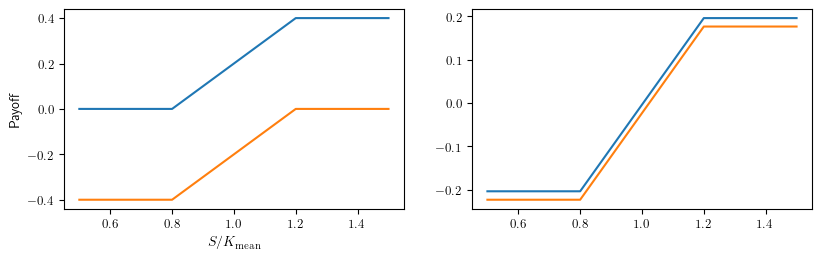

In [124]:
sVals = np.linspace(0.5,1.5,101)

c1 = call_payoff(sVals,0.8)
c2 = -call_payoff(sVals,1.2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,2.5))

axs[0].plot(sVals, c1+c2)
axs[0].set_xlabel(r'$S/K_{\rm mean}$')
axs[0].set_ylabel(r'Payoff')

p1 = put_payoff(sVals,0.8)
p2 = -put_payoff(sVals,1.2)

axs[0].plot(sVals, p1+p2)

# Right panel shows profit / loss (including BS cost of the options)
c1_profit = c1 - call_european(1.,0.8,0.05,0.25,1.)
c2_profit = c2 + call_european(1.,1.2,0.05,0.25,1.)

p1_profit = p1 - put_european(1.,0.8,0.05,0.25,1.,0.)
p2_profit = p2 + put_european(1.,1.2,0.05,0.25,1.,0.)

axs[1].plot(sVals, c1_profit+c2_profit)
axs[1].plot(sVals, p1_profit+p2_profit)

### Bear Spread

### Butterfly Spread

# Monte Carlo Approach

# Generating Brownian Motions